# When exactly does the anchoring to the lever happen?

In [ ]:
%load_ext autoreload
%autoreload 2

%run ../../setup_project.py
%run ../../generic_plot_functions.py
%run functions.py

import os.path
import shutil
import scipy
from scipy.stats import mannwhitneyu, pearsonr, wilcoxon, binned_statistic,friedmanchisquare,percentileofscore
from math import remainder, tau
import matplotlib.image as mpimg
from statannotations.Annotator import Annotator
from statannotations.stats.StatTest import StatTest
import matplotlib.patches as mpatches
import collections
from matplotlib.colors import LinearSegmentedColormap, Normalize

In [2]:
projectName, dataPath, dlcModelPath, myProject, sSessions = setup_project_session_lists(projectName="autopi_mec",dataPath=PROJECT_DATA_PATH,dlcModelPath="")

creating myProject, an autopipy.project object
Project name: autopi_mec
dataPath: /ext_drives/d91/data/projects/jingjie/Peng_et.al_2025_noInt/
dlcModelPath: 
Reading /ext_drives/d91/data/projects/jingjie/Peng_et.al_2025_noInt//sessionList
We have 180 testing sessions in the list
spikeA.Kilosort_session objects are in sSessions


## Check how long the different intervals are

In [3]:
fn = myProject.dataPath+"/results/reconstuctionDFAutoPI.csv"
print("Loading",fn)
dfAutoPI = pd.read_csv(fn)

Loading /ext_drives/d91/data/projects/jingjie/dyrad_data_files/results/reconstuctionDFAutoPI.csv


In [4]:
conditions = ['searchToLeverPath_light','searchToLeverPath_dark','atLever_light','atLever_dark', 'homingFromLeavingLeverToPeriphery_light', 'homingFromLeavingLeverToPeriphery_dark']

dfAutoPI_3 = dfAutoPI[dfAutoPI['condition'].isin(conditions)]

In [5]:
time_of_trial_intervals=dfAutoPI_3.groupby(['condition','session','trial'])['withinPathTime'].max().reset_index()

In [6]:
time_of_trial_intervals=pd.DataFrame(time_of_trial_intervals)
time_of_trial_intervals

,condition,session,trial,withinPathTime
0,atLever_dark,jp1084-05042022-0107,0,2.16
1,atLever_dark,jp1084-05042022-0107,1,1.96
2,atLever_dark,jp1084-05042022-0107,2,2.86
3,atLever_dark,jp1084-05042022-0107,3,5.68
4,atLever_dark,jp1084-05042022-0107,4,3.54
...,...,...,...,...
15801,searchToLeverPath_light,mn8599-11022022-0107,64,0.94
15802,searchToLeverPath_light,mn8599-11022022-0107,65,0.32
15803,searchToLeverPath_light,mn8599-11022022-0107,66,1.10
15804,searchToLeverPath_light,mn8599-11022022-0107,67,1.08


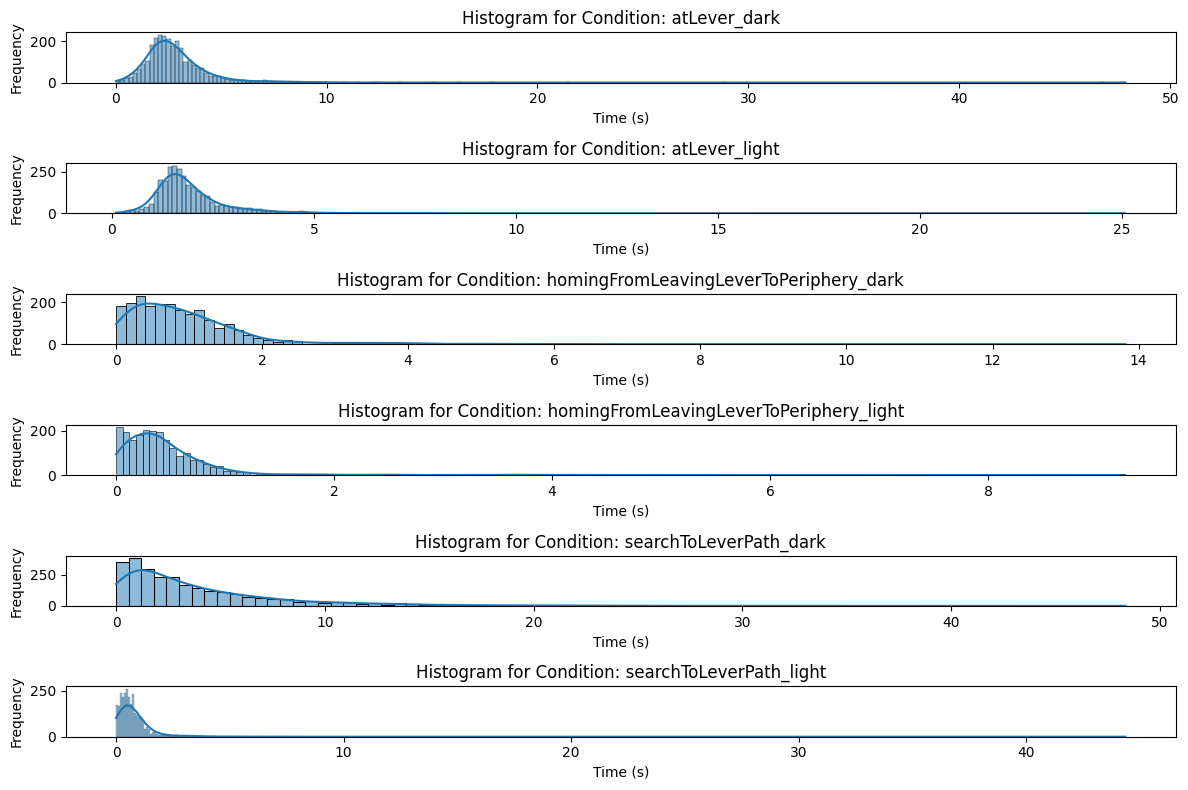

In [7]:
conditions = time_of_trial_intervals['condition'].unique()

# Set up the subplot grid
plt.figure(figsize=(12, 8))
num_conditions = len(conditions)
for i, condition in enumerate(conditions, 1):
    plt.subplot(num_conditions, 1, i)  # create a subplot for each condition
    sns.histplot(data=time_of_trial_intervals[time_of_trial_intervals['condition'] == condition], x='withinPathTime', kde=True)
    plt.title(f'Histogram for Condition: {condition}')
    plt.xlabel('Time (s)')
    plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

In [8]:
time_of_trial_intervals.groupby(['condition'])['withinPathTime'].mean()

condition
atLever_dark                               2.876698
atLever_light                              1.983327
homingFromLeavingLeverToPeriphery_dark     0.975525
homingFromLeavingLeverToPeriphery_light    0.454476
searchToLeverPath_dark                     3.961724
searchToLeverPath_light                    0.869370
Name: withinPathTime, dtype: float64

In [9]:
time_of_trial_intervals.groupby(['condition'])['withinPathTime'].std()

condition
atLever_dark                               2.022636
atLever_light                              1.181797
homingFromLeavingLeverToPeriphery_dark     0.988429
homingFromLeavingLeverToPeriphery_light    0.523451
searchToLeverPath_dark                     4.303680
searchToLeverPath_light                    1.860504
Name: withinPathTime, dtype: float64

In [10]:
time_of_trial_intervals.groupby(['condition'])['withinPathTime'].max()

condition
atLever_dark                               47.88
atLever_light                              25.08
homingFromLeavingLeverToPeriphery_dark     13.82
homingFromLeavingLeverToPeriphery_light     9.26
searchToLeverPath_dark                     48.34
searchToLeverPath_light                    44.36
Name: withinPathTime, dtype: float64

## Now make the plot about the time dynamics of the lever anchoring

In [12]:
fn = myProject.dataPath+"/results/model_distance_with_bins.csv"
if os.path.exists(fn):
    print(fn, "exists")
df_model_distance = pd.read_csv(fn)

/ext_drives/d91/data/projects/jingjie/dyrad_data_files/results/model_distance_with_bins.csv exists


In [13]:
#add a column interval
bin_by=0.4
time_min = df_model_distance['withinPathTime'].min()
time_max = df_model_distance['withinPathTime'].max()
bins = np.arange(time_min, time_max + bin_by, bin_by)
bin_centers = (bins[:-1] + bins[1:]) / 2  # Midpoints for each bin

# Use pd.cut to assign each time to a bin, then map the intervals to bin centers
df_model_distance['interval'] = pd.cut(df_model_distance['withinPathTime'], bins=bins, labels=bin_centers, right=False)
#df_model_distance['interval'] = df_model_distance['interval'].astype(float)  # Convert interval labels to floats


In [14]:
def fit_bivariate_von_mises_to_toroidal_coordinate(df,col1="v0Bridge",col2="v1Bridge"):
    """
    fit a bivariate von Mises distribution to the bridge coordinates in the toroidal space
    """
    x0 = df[col1][np.isfinite(df[col1])]
    x1 = df[col2][np.isfinite(df[col2])]
    if not x0.empty or x1.empty:
        x = np.stack([x0,x1]).T
        resK,resM,resA = fit_bivariate_von_mises(x)
        return pd.DataFrame({"k0":[resK[0]],
                             "k1":[resK[1]],
                             "k":[resK.mean()],
                            "mu0":[resM[0]],
                            "mu1":[resM[0]]})
    else:
        return pd.DataFrame({"k0":[np.nan],
                     "k1":[np.nan],
                     "k":[np.nan],
                    "mu0":[np.nan],
                    "mu1":[np.nan]})

In [15]:
fn = myProject.dataPath+"/results/dfLeverAnchoring_leverlocked.csv"
if os.path.exists(fn):
    dfLeverVonMises=pd.read_csv(fn)
else:
    dfLeverVonMises5=df_model_distance[df_model_distance.condition=='all_dark'].groupby(['session','interval']).apply(fit_bivariate_von_mises_to_toroidal_coordinate, 'predictedLeverCoordv0','predictedLeverCoordv1').reset_index()
    fn = myProject.dataPath+"/results/dfLeverAnchoring_leverlocked.csv"
    dfLeverVonMises5.to_csv(fn)
    

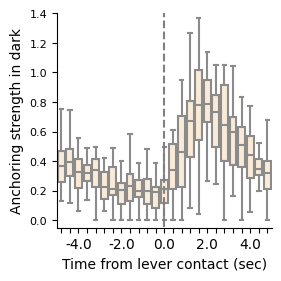

In [16]:
rowSize,colSize= figurePanelDefaultSize()
boxPlotColors = ['#ffecd1','#ff7d00','#15616d','#78290f']
fig = plt.figure(figsize=(rowSize*1.5, colSize*1.5), constrained_layout=True) # create a figure
mainSpec = fig.add_gridspec(ncols=1, nrows=1) # create a GridSpec object to a figure

ax=fig.add_subplot(mainSpec[0])
sns.boxplot(data=dfLeverVonMises, x= "interval", y="k",showfliers=False, color=boxPlotColors[0])
xticks = ax.get_xticks()
xtick_labels = np.round(np.arange(np.nanmin(dfLeverVonMises.interval), np.nanmax(dfLeverVonMises.interval),0.4), decimals=1)

# Set only every 5th label, making others empty
ax.set_xticks(xticks)  # Keep all tick positions
xtick_labels_filtered = [f"{label:.1f}" if label.is_integer() else '' for label in xtick_labels]
ax.set_xticklabels(xtick_labels_filtered)
ax.set_ylabel('Anchoring strength in dark')
ax.set_xlabel('Time from lever contact (sec)')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.tick_params(axis='y', which='major', labelsize=8)
plt.vlines(x=12,ymin=-0.12,ymax=1.4,linestyles='dashed', color='grey')
ax.set_ylim([-0.05,1.4])

plt.savefig('../../Output/Sup_Figure14.pdf', bbox_inches='tight', dpi=300)